In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import MeanAbsoluteError
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("E:\Datasets\SolarPrediction.csv")

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## Data Wrangling

In [5]:
df = data.copy()

In [6]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x: x.split()[0])

In [7]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [8]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [9]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [10]:
# extract the sunrise and sunset information using regular expression
df['RiseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(int)
df['RiseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['SetHour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['SetMinute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [11]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [13]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace=True)

In [14]:
df.head()


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
RiseHour                  0
RiseMinute                0
SetHour                   0
SetMinute                 0
dtype: int64

In [16]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

## Feature Selection using Correlation Matrix

In [17]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


<Axes: >

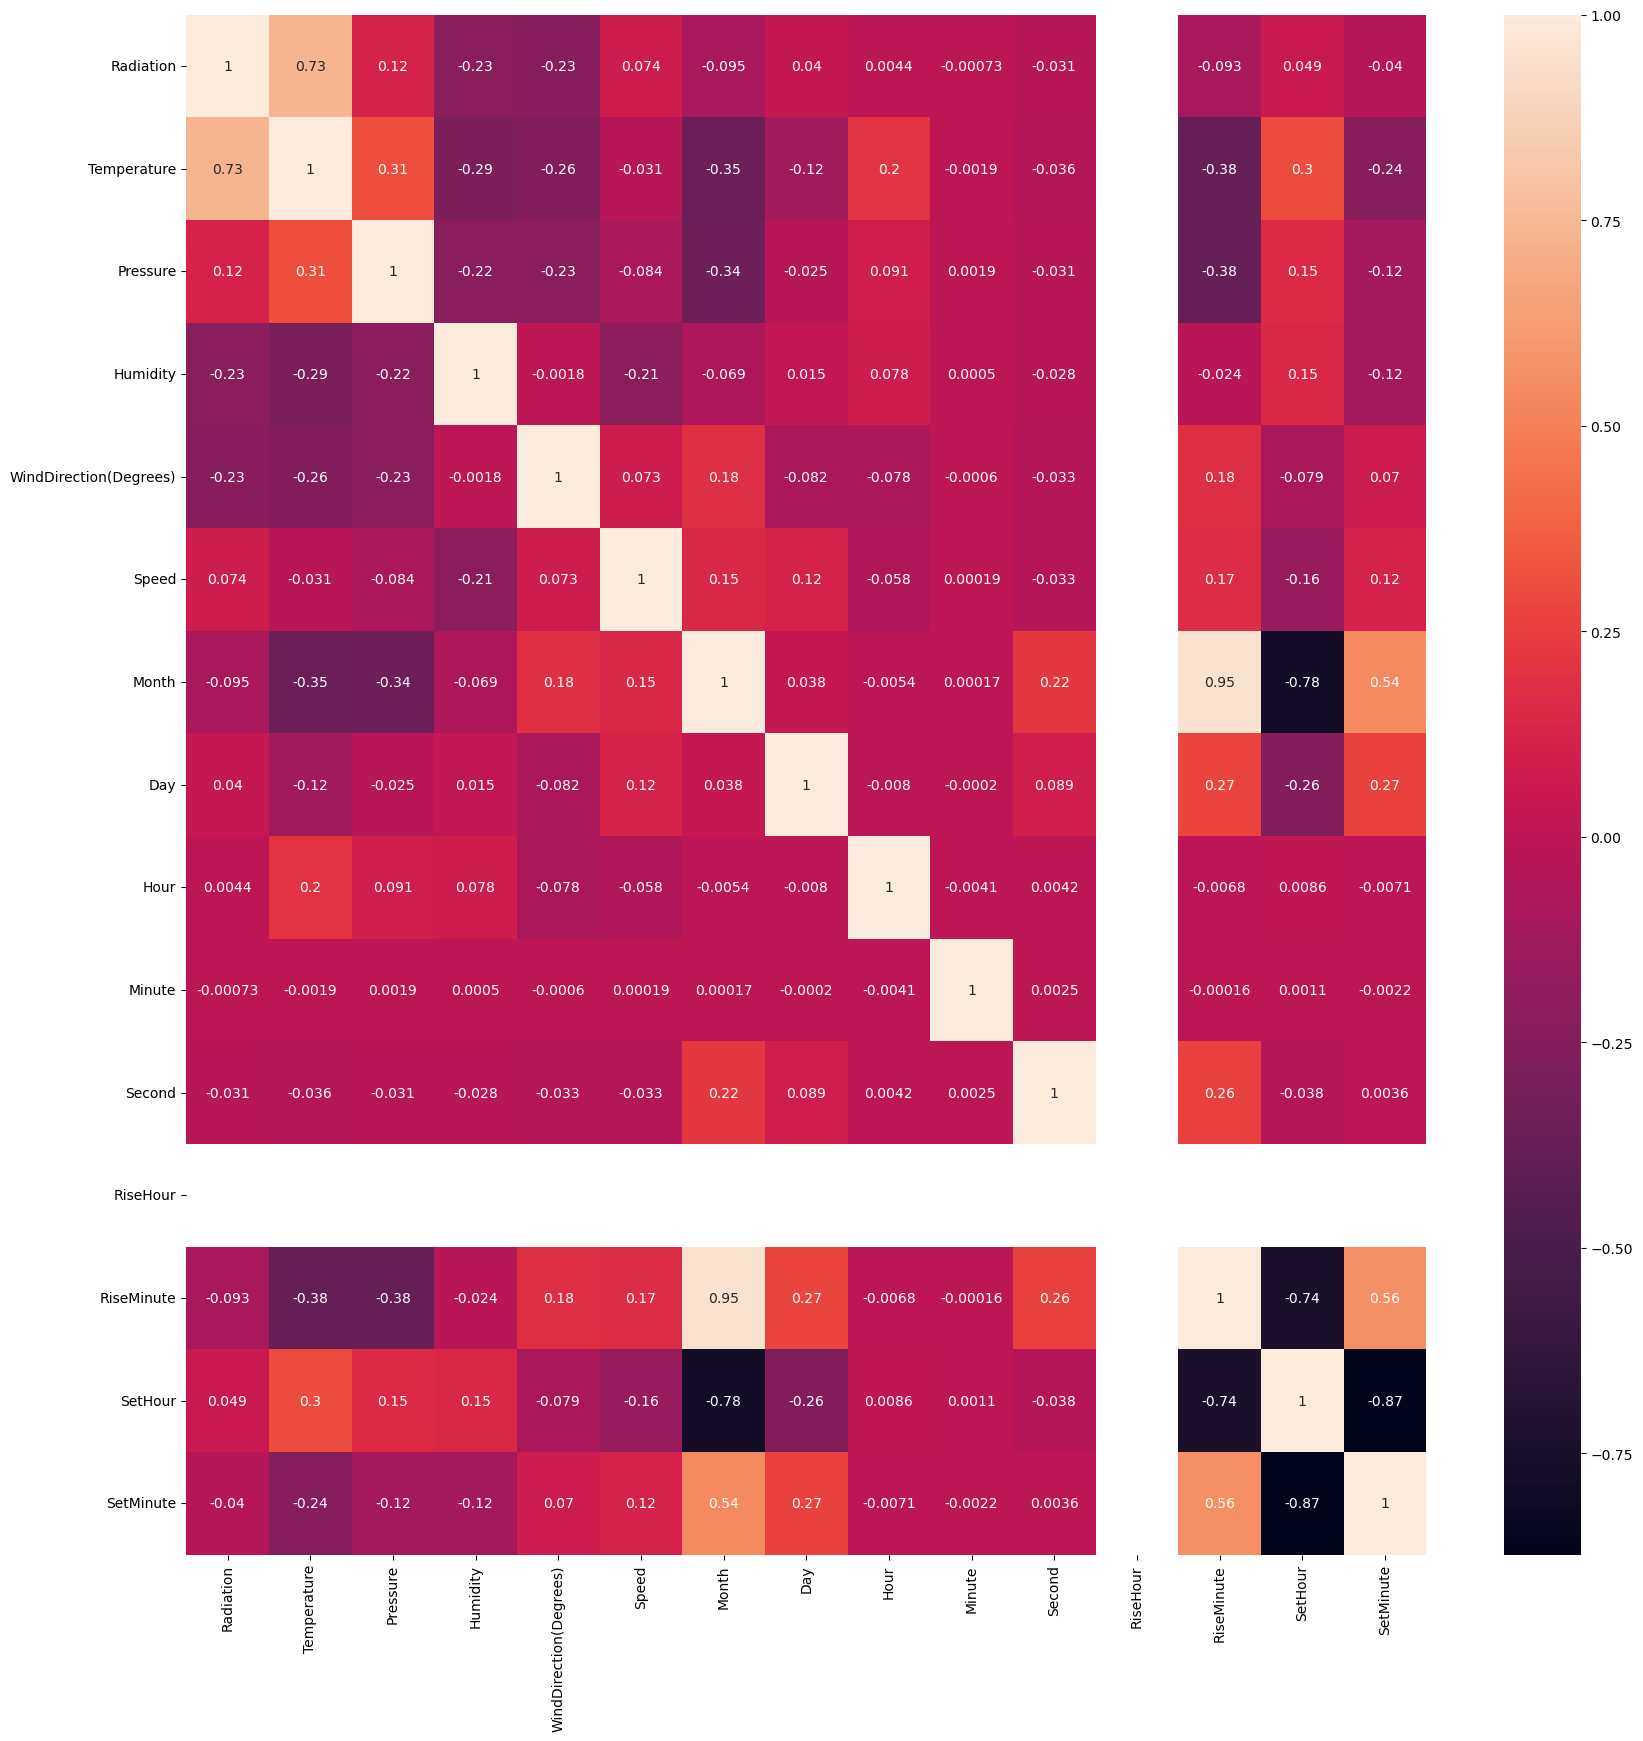

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)

## Feature Selection using SelectKBest Method

In [19]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [20]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [21]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [22]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [23]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp'] 

In [24]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,SetHour,12207.531454
5,Month,4684.579610
11,RiseMinute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,SetMinute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


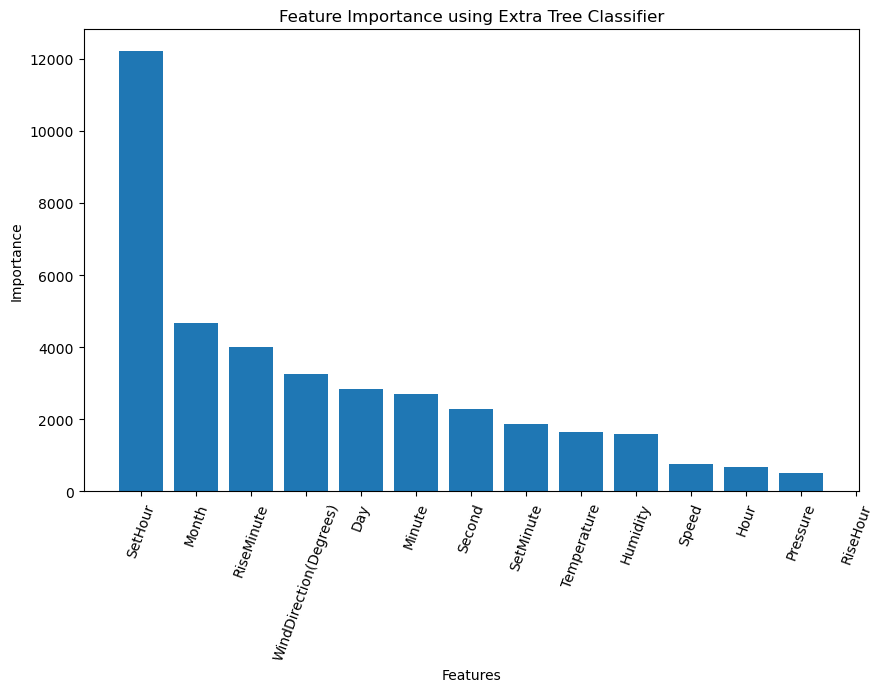

In [25]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

## Feature Selection using Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(verbose=2, n_estimators=5)
model.fit(scaled_input_features, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.8s finished


RandomForestClassifier(n_estimators=5, verbose=2)

In [27]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.165692
Minute,0.131952
Speed,0.111282
Second,0.110905
Humidity,0.110622
Hour,0.092535
Pressure,0.080002
Temperature,0.079773
Day,0.044466
SetMinute,0.034606


In [95]:
from joblib import dump, load
import gc
dump(model, 'model.joblib', compress=3)  # Save with compression
model = None  # Clear the variable
gc.collect()

0

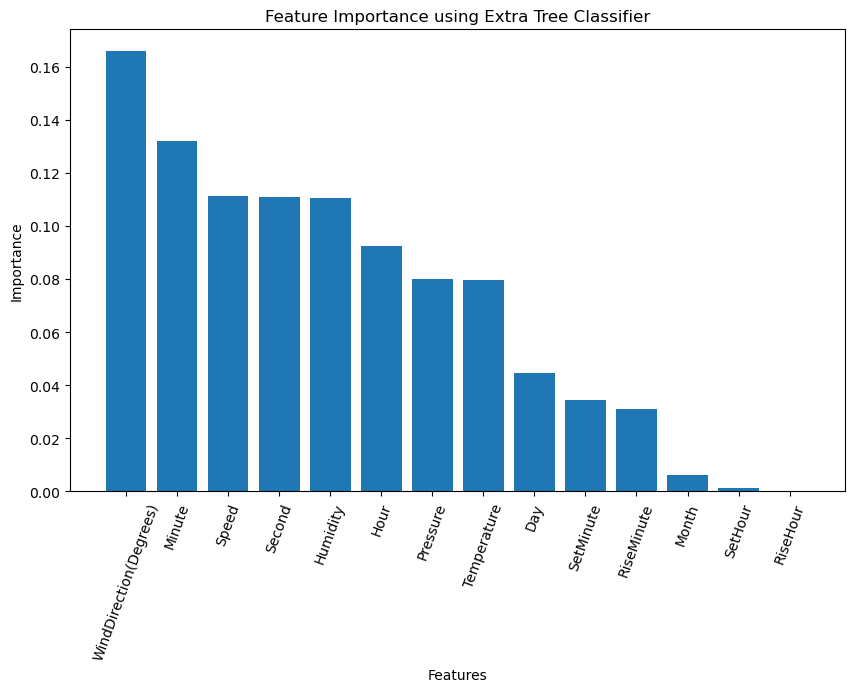

In [28]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

## Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

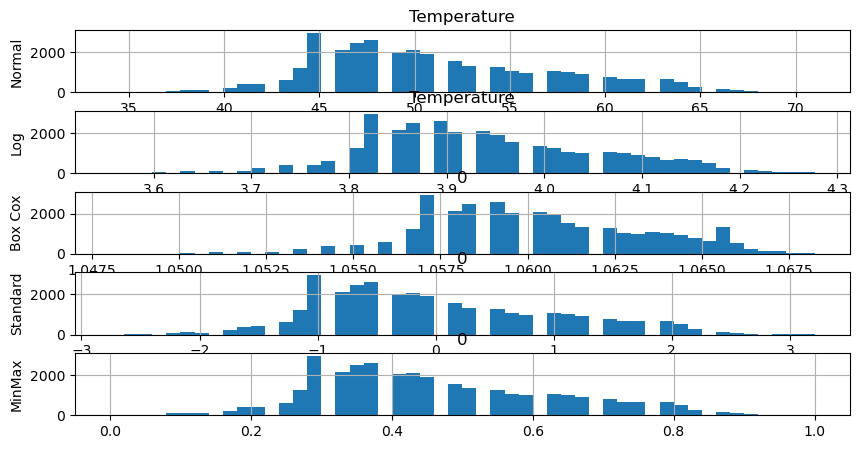

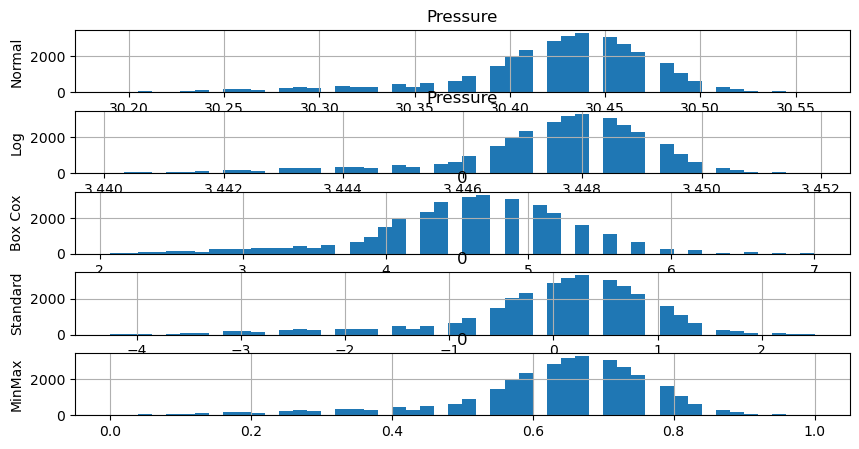

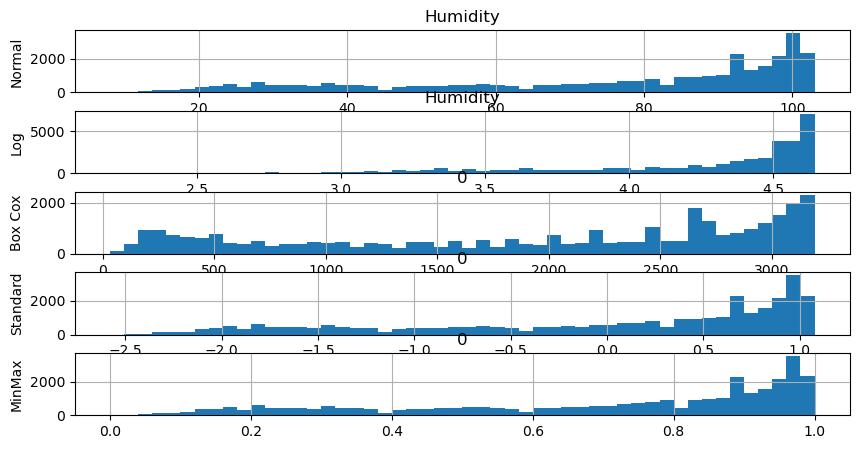

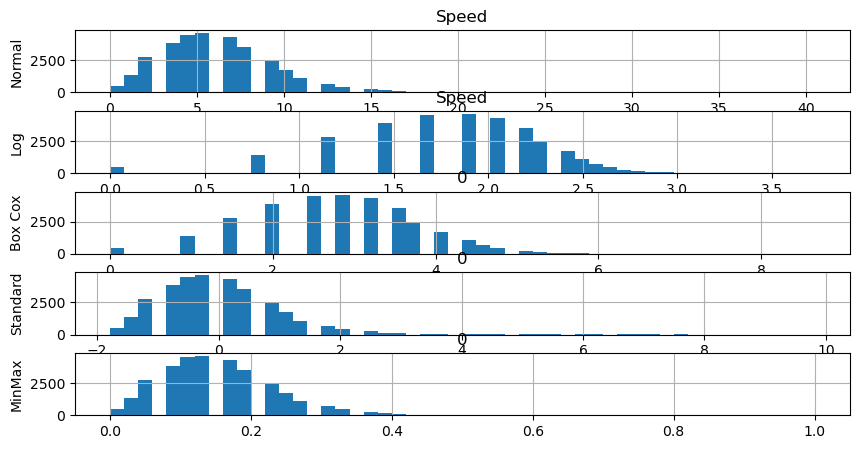

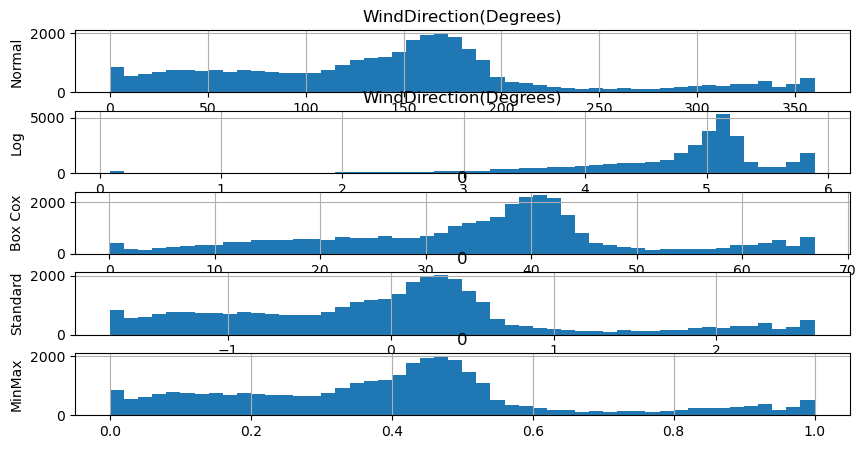

In [29]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [30]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [31]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,RiseHour,RiseMinute,SetHour,SetMinute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


## Preparing data - Standardisation and Splitting

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [33]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

## Prediction with XGBoost

In [34]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [35]:
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
y_pred = model.predict(xtest)

In [37]:
comparison_df = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
print(comparison_df.head())

       Actual   Predicted
22830    1.24    0.340335
17281    1.22    1.652490
6136   206.02  188.609619
17582    1.22    3.205139
20747    1.20    1.049021


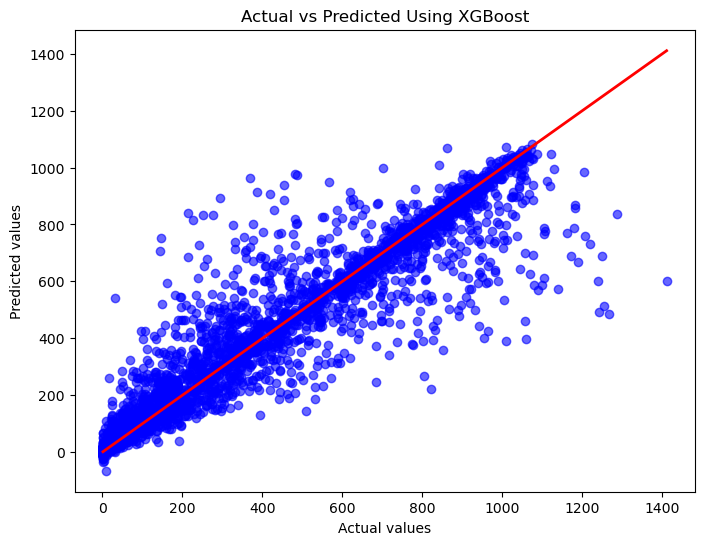

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, color='blue', alpha=0.6)
plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], color='red', lw=2)  # Ideal line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Using XGBoost')
plt.show()

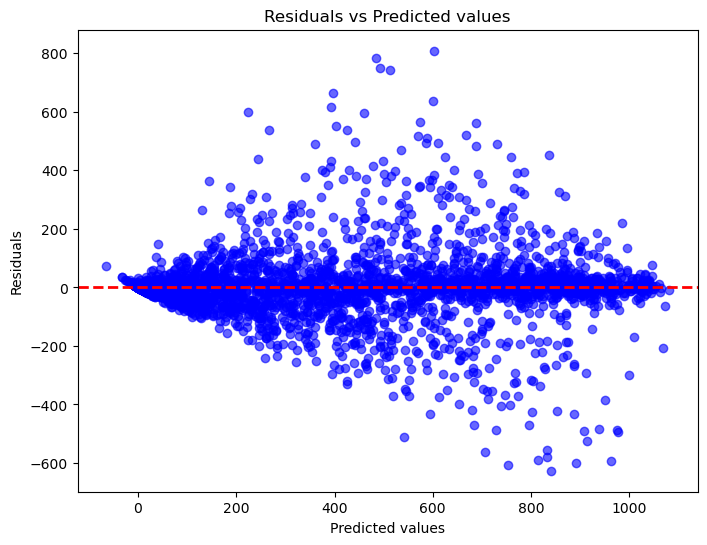

In [39]:
residuals = ytest - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

In [40]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 81.8749


In [41]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 81.87
R2: 0.93


## Using MultiLayer Perceptron for prediction

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [53]:
modelMLP = None
modelMLP = Sequential()
# Input layer
modelMLP.add(Dense(128, activation='relu', input_dim=14))
modelMLP.add(Dropout(0.33))

# Hidden layers
modelMLP.add(Dense(64, activation='relu'))
modelMLP.add(Dropout(0.33))

modelMLP.add(Dense(32, activation='relu'))
modelMLP.add(Dropout(0.33))

# Output layer
modelMLP.add(Dense(1, activation='linear'))

# Compile the model
modelMLP.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))

# Display the model summary
print(modelMLP.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [54]:
history = modelMLP.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 159.1054 - mse: 91846.3906 - val_loss: 76.6339 - val_mse: 21922.4141
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 83.9157 - mse: 27043.8242 - val_loss: 68.3876 - val_mse: 17785.3145
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 79.0359 - mse: 23859.1484 - val_loss: 65.7404 - val_mse: 16497.3574
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 78.4811 - mse: 23194.2168 - val_loss: 62.0064 - val_mse: 15038.1445
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.4103 - mse: 23025.8027 - val_loss: 59.1166 - val_mse: 14136.9746
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 71.8994 - mse: 20095.0977 - val_loss: 57.1651 - val_mse: 13486.2607
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 69.7288 - mse: 19270.3516 - val_loss: 53.7629 - val_mse: 12268.5176
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 69.1635 - mse: 18942.0137 - val_loss: 54.45

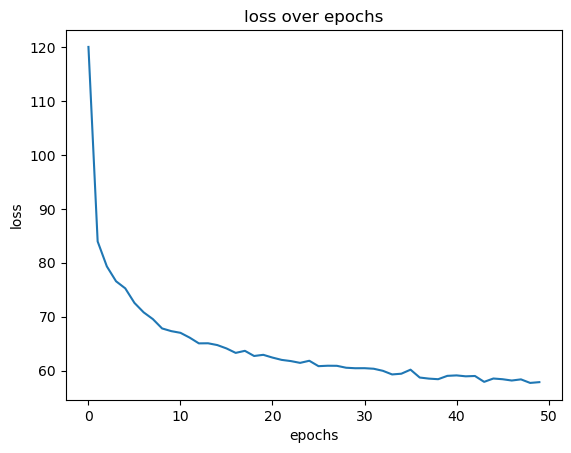

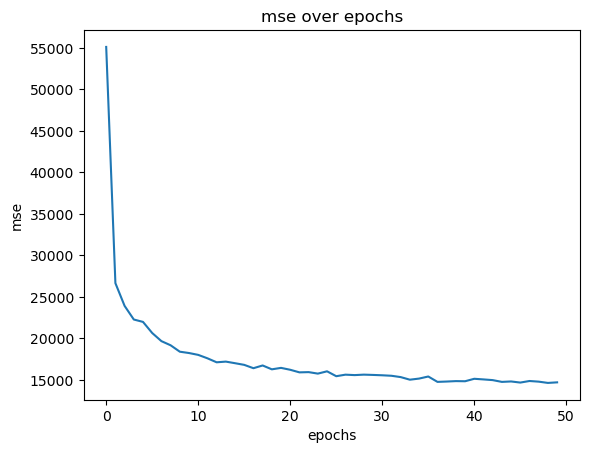

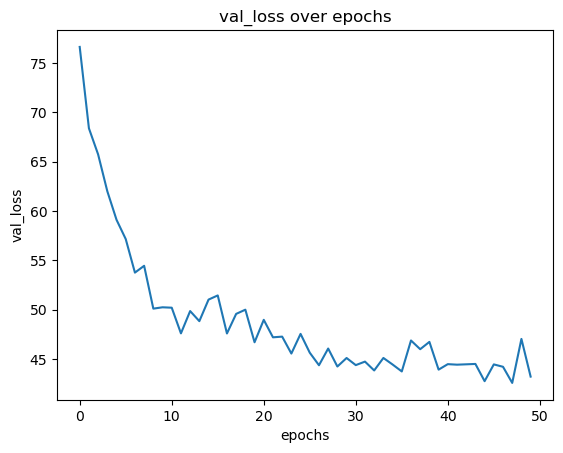

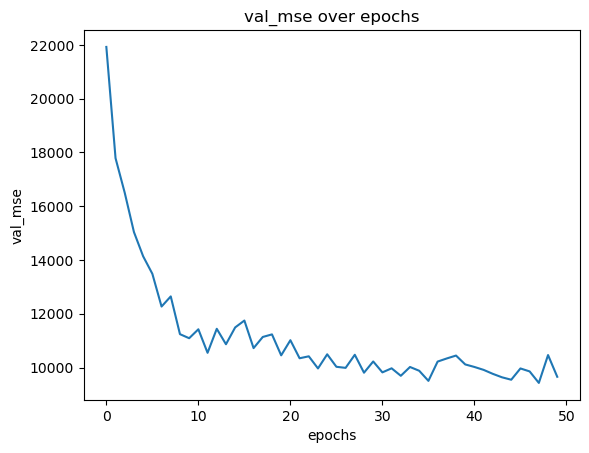

In [55]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [56]:
scores = modelMLP.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42.8318 - mse: 9554.5156
Mean absolute error:  41.416542053222656


In [57]:
mean_absolute_error(ytest, modelMLP.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


41.41653977323066

In [48]:
mean_baseline = [target_cont.mean()] * len(target_cont)
baseline_mae = mean_absolute_error(target_cont, mean_baseline)

print(f"Baseline MAE: {baseline_mae}")

Baseline MAE: 25904.104630934147


In [49]:
ytest

22830      1.24
17281      1.22
6136     206.02
17582      1.22
20747      1.20
          ...  
22904    564.25
15978      1.25
8342       1.19
22838      1.28
9120       1.20
Name: Radiation, Length: 6538, dtype: float64

In [58]:
y_predict  = modelMLP.predict(xtest)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [59]:
comparison_df = pd.DataFrame({'Actual': ytest, 'Predicted': y_predict.ravel()})
print(comparison_df.head())

       Actual   Predicted
22830    1.24    1.229482
17281    1.22    1.229482
6136   206.02  249.204102
17582    1.22    1.229482
20747    1.20    1.229482


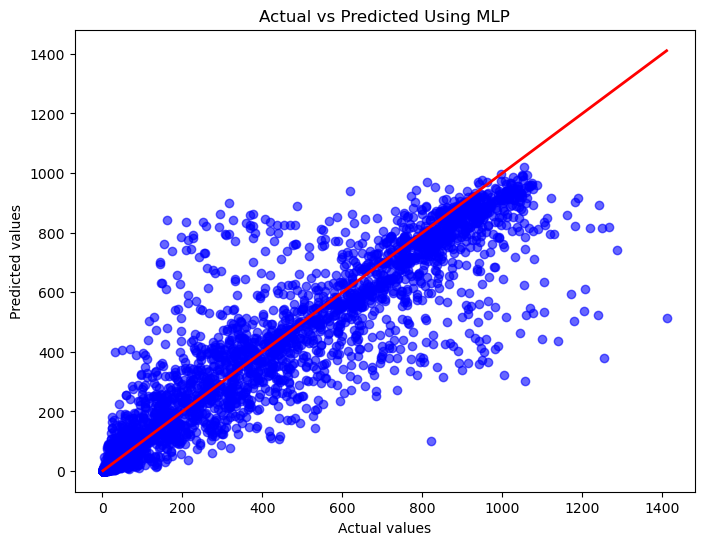

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_predict, color='blue', alpha=0.6)
plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], color='red', lw=2)  # Ideal line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Using MLP')
plt.show()

In [61]:
modelMLP.save('my_model.keras')